### Import Libraries


In [143]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as ss
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# define the neural networks
from keras import regularizers, optimizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, GlobalAveragePooling1D

### 1. Formatting raw data to Deep Convolutional Neural Network


#### standardize the data before combining or stacking the attributes. (Note that all the reported attributes are measured in the same units (gravity) and in similar order of magnitude so standardizing may have marginal effects)

In [121]:
##load the train data set
TrainData= loadmat('./Desktop/DataSet/rawSensorData_train.mat')
##display (TrainData)

##rename all features (6 features in total)
gyro_x_train = TrainData['body_gyro_x_train']
gyro_y_train = TrainData['body_gyro_y_train']
gyro_z_train = TrainData['body_gyro_z_train']

acc_x_train = TrainData ['total_acc_x_train']
acc_y_train = TrainData ['total_acc_y_train']
acc_z_train = TrainData ['total_acc_z_train']




In [122]:
##load test data set
TestData = loadmat('./Desktop/DataSet/rawSensorData_test.mat')
##display(TestData)

##rename all features (6 features in total)
gyro_x_test = TestData['body_gyro_x_test']
gyro_y_test = TestData['body_gyro_y_test']
gyro_z_test = TestData['body_gyro_z_test']

acc_x_test = TestData ['total_acc_x_test']
acc_y_test = TestData ['total_acc_y_test']
acc_z_test = TestData ['total_acc_z_test']


In [123]:
##standardizing the train and test data set
sc = ss()

##for gyroscope
gyro_x_train_1 = sc.fit_transform(gyro_x_train)
gyro_x_test_1 = sc.transform(gyro_x_test)

gyro_y_train_1 = sc.fit_transform(gyro_y_train)
gyro_y_test_1 = sc.transform(gyro_y_test)

gyro_z_train_1 = sc.fit_transform(gyro_z_train)
gyro_z_test_1 = sc.transform(gyro_z_test)

##for accelerometer
acc_x_train_1 = sc.fit_transform(acc_x_train)
acc_x_test_1 = sc.transform(acc_x_test)

acc_y_train_1 = sc.fit_transform(acc_y_train)
acc_y_test_1 = sc.transform(acc_y_test)

acc_z_train_1 = sc.fit_transform(acc_z_train)
acc_z_test_1 = sc.transform(acc_z_test)

#### Consider each attribute in the training [7352,128] will be stacked in the “axis=2” dimension (counting from 0), often called an input channel. We use np.stack so we obtain [7352,128,6] array, corresponding to [axis=0,1,2] as [num_samples, num_timesteps, num_attributes]. 

In [124]:
TrainData1 = np.stack([acc_x_train_1,
                      acc_y_train_1,
                      acc_z_train_1,
                      gyro_x_train_1,
                      gyro_y_train_1,
                      gyro_z_train_1], axis = 2)
##display (TrainData1[0:5])
TrainData1.shape

(7352, 128, 6)

####  Repeat for test data. 


In [125]:
TestData1 = np.stack([acc_x_test_1,
                      acc_y_test_1,
                      acc_z_test_1,
                      gyro_x_test_1,
                      gyro_y_test_1,
                      gyro_z_test_1], axis = 2)
##display (TestData1[0:5])
TestData1.shape

(2947, 128, 6)

#### Convert labels (1 to 5) to 0 to 4, and perform one-hot encoding.

In [126]:
#obtain the labels. 
labels = loadmat('./Desktop/DataSet/labels.mat')
train_labels = labels['train_labels']
test_labels = labels['test_labels']

print('train label shape', train_labels.shape)
print('test label shape',test_labels.shape)

#encode/transform so the class starts at 0 to 4 rather than 1 to 5.
dict = {1:0,2:1,3:2,4:3,5:4}
train_labels = np.vectorize(dict.get)(train_labels)
test_labels = np.vectorize(dict.get)(test_labels)


#convert to one-hot
train_labels_enc = to_categorical(train_labels)
test_labels_enc = to_categorical(test_labels)

# display (train_labels_enc [0:5])
# display (test_labels_enc [0:5])

train label shape (7352, 1)
test label shape (2947, 1)


### 2. Implement the Deep Neural Network Classifier: Note the parameter and layer tuning is usually up to the designer, here is my architecture and tuning which converges. If your computer has “Out of memory” problem, consider reducing the number of neurons, and the batchsize in step h.


In [127]:
#parameters for neural net
num_inputs = TrainData1.shape[1] # Total number 0f input variables (per sample)
num_channels = TrainData1.shape[2] #number of channels (1)
num_labels = train_labels_enc.shape[1] # Total number of output labels - 3.

print (num_inputs)
print (num_channels)
print (num_labels)

128
6
5


#### a. Use a Conv1D layer with 100 filters, a sliding kernel filter of 10, padding=’causal’, Relu activation, and input shape of [num_timesteps, num_attributes]


In [128]:
#build CNN MODEL
model = Sequential()  
model.add(Conv1D(100, 10, padding='causal', activation='relu', input_shape=(num_inputs, num_channels)))
model.add(Activation('relu'))

#### b. Add another Conv1D layer with 150 filters, sliding kernel of 20, padding=’causal’, Relu activation. 

In [129]:
model.add(Conv1D(150, 20, padding='causal', activation='relu', input_shape=(num_inputs, num_channels)))
model.add(Activation('relu'))

#### c. Use the “GlobalAveragePooling1D” to reduce the convolutional output to a 1D vector to use as features to a standard neural network (dense layer and output) 

In [130]:
model.add(GlobalAveragePooling1D())

#### d. Add a dense layer with 128 neurons, followed by ‘relu” activation. 

In [131]:
model.add(Dense(128))
model.add(Activation('relu'))

#### e. Add a dropout layer with dropout probability of 50%

In [132]:
model.add(Dropout(0.5))

#### f. In the output layer, specify a N=5 neuron output, with ‘softmax’ activation 

In [133]:
##num_labels, N = 5 neuron output
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 100)          6100      
_________________________________________________________________
activation_6 (Activation)    (None, 128, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 150)          300150    
_________________________________________________________________
activation_7 (Activation)    (None, 128, 150)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               19328     
_________________________________________________________________
activation_8 (Activation)    (None, 128)              

#### g. Compile the model, using ‘adam’ optimizer, loss as ‘categorical_crossentropy’, and metrics of [‘accuracy’]. 

In [134]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### h. Fit (train) the model using the training [7352,128,6] features and train_label for 20 epoch. Specify a batch_size=256. (or smaller batch_size depending on your hardware) 

In [135]:
history = model.fit(TrainData1, train_labels_enc, batch_size= 256, epochs=20)  


Epoch 1/20
7352/7352 [==============================] - 70s 9ms/step - loss: 0.7275 - accuracy: 0.6999
Epoch 2/20
7352/7352 [==============================] - 71s 10ms/step - loss: 0.2666 - accuracy: 0.8936
Epoch 3/20
7352/7352 [==============================] - 71s 10ms/step - loss: 0.1656 - accuracy: 0.9368
Epoch 4/20
7352/7352 [==============================] - 70s 10ms/step - loss: 0.1381 - accuracy: 0.9438
Epoch 5/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.1241 - accuracy: 0.9474
Epoch 6/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.1161 - accuracy: 0.9491
Epoch 7/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.1080 - accuracy: 0.9531
Epoch 8/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.1082 - accuracy: 0.9529
Epoch 9/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.1016 - accuracy: 0.9559
Epoch 10/20
7352/7352 [==============================] - 69s 9ms/step 

#### i. Evaluate the results of the model on the [2549,128,6] test feature and test_label.

In [136]:
test_loss, test_acc = model.evaluate(TestData1,test_labels_enc, verbose=2)
print('\nTest loss:', test_loss)  
print('\nTest accuracy:', (test_acc*100))


Test loss: 0.4555106203815857

Test accuracy: 91.00780487060547


### Anal


#### a. Print the model.summary(). For each layer, using the output shape as a guide, verify the number of parameters (Param #) is correct. 
<b/>i. Hint 1: In the conv layers, each filter has a certain number of neurons for the convolution weights per [num_attributes], 
<br/>ii. Hint 2: https://keras.io/layers/pooling/ 
<br/>iii. Hint 3: Dense layers: output = Wx+b 

In [137]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 100)          6100      
_________________________________________________________________
activation_6 (Activation)    (None, 128, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 150)          300150    
_________________________________________________________________
activation_7 (Activation)    (None, 128, 150)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 150)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               19328     
_________________________________________________________________
activation_8 (Activation)    (None, 128)              

In [138]:
print ('The formula is : input channels * weights *filters + biases')
print ('The formula is :  inputs * outputs (x) + biases(b) \n\n')


print('For Layer 1: \n' 
      'input channels = 6,\n'
      'weights = 10 ,\n' 
      'filters = 100 ,\n'
      'biases = 100(1 per filter)\n'
      'Param Number = %d' % (6*10*100+100))
print ('''
  ''')


print('For Layer 2: \n' 
      'input channels = 100,\n'
      'weights = 20 ,\n' 
      'filters = 150 ,\n'
      'biases = 150(1 per filter)\n'
      'Param Number = %d' % (100*20*150+150))
print ('''
  ''')

print('For Layer 3: \n' 
      'inputs = 20 ,\n' 
      'outputs = 128 ,\n'
      'biases = 128 \n'
      'Param Number = %d' % (150*128+128))
print ('''
  ''')


print('For Layer 4: \n' 
      'inputs = 128 ,\n' 
      'outputs = 128 ,\n'
      'biases = 128 \n'
      'Param Number = %d' % (128*128+128))
print ('''
  ''')

print('For Layer 5: \n' 
      'inputs = 128 ,\n' 
      'outputs = 5 ,\n'
      'biases = 5 \n'
      'Param Number = %d' % (128*5+5))
print ('''
  ''')



The formula is : input channels * weights *filters + biases
The formula is :  inputs * outputs (x) + biases(b) 


For Layer 1: 
input channels = 6,
weights = 10 ,
filters = 100 ,
biases = 100(1 per filter)
Param Number = 6100

  
For Layer 2: 
input channels = 100,
weights = 20 ,
filters = 150 ,
biases = 150(1 per filter)
Param Number = 300150

  
For Layer 3: 
inputs = 20 ,
outputs = 128 ,
biases = 128 
Param Number = 19328

  
For Layer 4: 
inputs = 128 ,
outputs = 128 ,
biases = 128 
Param Number = 16512

  
For Layer 5: 
inputs = 128 ,
outputs = 5 ,
biases = 5 
Param Number = 645

  


#### b. Plot the training cross entropy loss, the training accuracy with the number of epoch (full iterations over dataset) in the data.

dict_keys(['loss', 'accuracy'])


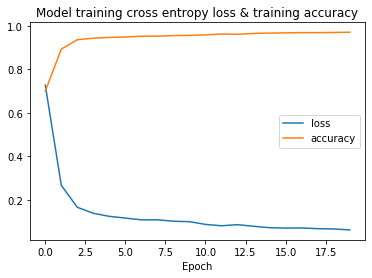

In [139]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy']) 
plt.title('Model training cross entropy loss & training accuracy')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center right')

#### c. Output the confusion matrix and accuracy for both training and test data with deep neural network. 

In [140]:
y_pred_test = model.predict (TestData1)
cm_test = confusion_matrix(test_labels_enc.argmax(axis=1), y_pred_test.argmax(axis=1))

y_pred_train = model.predict(TrainData1)
cm_train = confusion_matrix(train_labels_enc.argmax(axis=1), y_pred_train.argmax(axis=1))


print('Accuracy for training set for neural network = {}'.format((np.trace(cm_train))/len(train_labels_enc)))
print('The confusion matrix for training set for neural network is\n',cm_train)

print()

print('Accuracy for test set for neural network = {}'.format((np.trace(cm_test))/len(test_labels_enc)))
print('The confusion matrix for test set for neural network is\n', cm_test)

Accuracy for training set for neural network = 0.9789173014145811
The confusion matrix for training set for neural network is
 [[1407    0    0    0    0]
 [   0 1207    0   79    0]
 [   0    0 2059    0    0]
 [   0   74    0 1300    0]
 [   0    0    2    0 1224]]

Accuracy for test set for neural network = 0.9100780454699695
The confusion matrix for test set for neural network is
 [[537   0   0   0   0]
 [  0 401  25  65   0]
 [  0   0 869   0  22]
 [  0  96   3 431   2]
 [  0   0  52   0 444]]


#### d. Output the softmax probability of the first 5 test samples and compare with true label. 

In [141]:
predict = model.predict (TestData1 [0:5])


print ('The Predicted output for first 5 test samples is \n' ,[np.argmax(x) for x in predict])
print ('The Actual output for firsr 5 test samples is \n', test_labels[0:5].reshape(-1))

The Predicted output for first 5 test samples is 
 [3, 3, 3, 3, 3]
The Actual output for firsr 5 test samples is 
 [3 3 3 3 3]


#### e. For the deep neural network, based on confusion matrix and previous analysis, which classes of activities are the most difficult and which ones conversely are easy to “classify”? 

In [142]:
label = ['Laying', 'Sitting', 'Climbing Stairs', 'Standing', 'Walking']


result=metrics.classification_report(test_labels, y_pred_test.argmax(axis = 1), labels=None, target_names= label, 
                                      sample_weight=None, digits=2, output_dict=False)
print (result)

                 precision    recall  f1-score   support

         Laying       1.00      1.00      1.00       537
        Sitting       0.81      0.82      0.81       491
Climbing Stairs       0.92      0.98      0.94       891
       Standing       0.87      0.81      0.84       532
        Walking       0.95      0.90      0.92       496

       accuracy                           0.91      2947
      macro avg       0.91      0.90      0.90      2947
   weighted avg       0.91      0.91      0.91      2947



The easiest activity to classify is Laying.
<br/>Sitting and Standing are the most to difficult to classify.
<br/>Climbing stairs and Walking are often confused and are also hard to classify.

#### f. What parameters are modifiable to the analyst in a deep neural network? You may use terminology used in the Keras libraries to guide your answer. 

The learning rate can be changed, The number of epochs can be increased, number of layers increased, sgd optimizer could be used, regularization can be introduced, differnt activations could have been used also, loss functions, and performance metrics also changed

#### g. Discuss any advantages or applications of using convolutional layers over choosing hand-crafted statistical features (i.e. mean, standard deviation). *Note that the current dataset, the task (predicting the activity) is already quite separable with the hand-crafted features [Assignment 3 from the 3D plots].

Convolutional layers can be used for image recognition where the features are not easily classifiable. In CNN, the features are learned by the classifier and this comes very handy in image recognition which annot be easily hand crafted.